In [1]:
# USAGE
# python train.py
# import the necessary packages
from pyimagesearch.dataset import SegmentationDataset
from pyimagesearch.model import UNet
from pyimagesearch import config
from torch.nn import BCEWithLogitsLoss # sigmoid + BCEloss(for one class!)
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms as tf
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

%matplotlib inline

In [2]:
#make image list for directory written!
total_imageList = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))
total_maskList = sorted(list(paths.list_images(config.MASK_DATASET_PATH)))
#total_imageList is image_path_list whose element ends with .png

#split train and test set!
split = train_test_split(total_imageList, total_maskList, test_size=config.TEST_SPLIT_RATIO, random_state=42)

#unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]  #mask is the label of segmentation!

# TEST_PATHS: output/test_paths.txt
print("[INFO] saving testing image paths...")
f = open(config.TEST_PATHS, 'w')
f.write('\n'.join(testImages))
f.close()

# print(testImages) 
# 'dataset/train/images/25db231ea0.png', 'dataset/train/images/dfd3138198.png', 'dataset/train/images/2425501bf4.png'

[INFO] saving testing image paths...


In [3]:
#define transformation
compose = tf.Compose([
    tf.ToPILImage(), 
    tf.Resize((config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDGH)), 
    tf.ToTensor()
    ])

#create the train and test datasets
train_dataset = SegmentationDataset(imagePathList = trainImages, maskPathList = trainMasks, transforms = compose)
test_dataset = SegmentationDataset(imagePathList = testImages, maskPathList = testMasks, transforms = compose)
print(f"[INFO] found {len(train_dataset) } examples in the training set...")
print(f"[INFO] found {len(test_dataset)} examples in the test set...")

#create the train and test dataloaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=config.BATCH_SIZE,
                         pin_memory=config.PIN_MEMORY, num_workers=(os.cpu_count()//5))
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=config.BATCH_SIZE, 
                        pin_memory=config.PIN_MEMORY, num_workers=(os.cpu_count()//5))

[INFO] found 3400 examples in the training set...
[INFO] found 600 examples in the test set...


In [4]:
print('length of total dataset: ',len(total_imageList))
print('length of train_data: ', len(trainImages))
print('length of test data: ', len(testImages))
print('length of train data loader: ', len(train_loader))
print('length of test data loader ', len(test_loader))


length of total dataset:  4000
length of train_data:  3400
length of test data:  600
length of train data loader:  54
length of test data loader  10


In [5]:
#initialize out UNet model
unet = UNet().to(config.DEVICE)

#initialize loss function and optimizer
costFunc = BCEWithLogitsLoss()
optimizer = Adam(unet.parameters(), lr = config.INIT_LR)

trainSteps = len(train_dataset)/config.BATCH_SIZE
testSteps = len(test_dataset)/config.BATCH_SIZE

#initialize a dictionary to store training history
H = {'train_loss': [], "test_loss": []}

In [6]:
#get latest model number from latest_model_number.txt
f = open('output/latest_model_number.txt', 'r')
latest_model_number = f.read()
f.close()

#update model number at latest_model_number.txt
f = open('output/latest_model_number.txt', 'w')
f.write(str(int(latest_model_number) + 1))
f.close()

In [7]:
#loop over epochs
print('[INFO] training the network...')
startTime = time.time()

for e in tqdm(range(config.NUM_EPOCH)):
    totalTrainLoss = 0
    totalTestloss = 0

    unet.train()
    for (i, (x, y)) in enumerate(train_loader):
        (x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))

        optimizer.zero_grad()
        prediction = unet(x)
        cost = costFunc(prediction, y)
        cost.backward()
        optimizer.step()
        totalTrainLoss += cost

    with torch.no_grad():
        unet.eval()
        for(x, y) in test_loader:
            (x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
            prediction = unet(x)
            cost = costFunc(prediction, y)
            totalTestloss += cost

    avgTrainLoss = totalTrainLoss/len(train_loader)
    avgTestLoss = totalTestloss/len(test_loader)

    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

    print('[INFO] EPOCH: {}/{} Train loss:{:2.4f} Test loss:{:2.4f}'.format(e+1, config.NUM_EPOCH, avgTrainLoss, avgTestLoss))

print(f"final train cost: {H['train_loss'][-1]} \n final test cost: {H['test_loss'][-1]}")
print("[INFO] total time taken to train the model: {:2.5f}s".format(time.time()-startTime))
model_path = config.BASE_OUTPUT + "/unet#" + str(latest_model_number) + "_cost:{:2.4f}".format(H['test_loss'][-1]) +'.pth'

f = open(config.MODEL_PATH, 'a')
f.write(model_path + '\n')
f.close()

torch.save(unet, model_path)

[INFO] training the network...


  2%|▏         | 1/50 [00:03<03:06,  3.81s/it]

[INFO] EPOCH: 1/50 Train loss:0.5706 Test loss:0.5454


  4%|▍         | 2/50 [00:06<02:41,  3.36s/it]

[INFO] EPOCH: 2/50 Train loss:0.5491 Test loss:0.5317


  6%|▌         | 3/50 [00:09<02:32,  3.24s/it]

[INFO] EPOCH: 3/50 Train loss:0.5190 Test loss:0.5846


  8%|▊         | 4/50 [00:12<02:25,  3.16s/it]

[INFO] EPOCH: 4/50 Train loss:0.4709 Test loss:0.4123


 10%|█         | 5/50 [00:16<02:20,  3.13s/it]

[INFO] EPOCH: 5/50 Train loss:0.4269 Test loss:0.3918


 12%|█▏        | 6/50 [00:19<02:17,  3.13s/it]

[INFO] EPOCH: 6/50 Train loss:0.4100 Test loss:0.3800


 14%|█▍        | 7/50 [00:22<02:13,  3.11s/it]

[INFO] EPOCH: 7/50 Train loss:0.4141 Test loss:0.3813


 16%|█▌        | 8/50 [00:25<02:10,  3.10s/it]

[INFO] EPOCH: 8/50 Train loss:0.3984 Test loss:0.3950


 18%|█▊        | 9/50 [00:28<02:07,  3.11s/it]

[INFO] EPOCH: 9/50 Train loss:0.4018 Test loss:0.3852


 20%|██        | 10/50 [00:31<02:03,  3.10s/it]

[INFO] EPOCH: 10/50 Train loss:0.3888 Test loss:0.3627


 22%|██▏       | 11/50 [00:34<02:01,  3.11s/it]

[INFO] EPOCH: 11/50 Train loss:0.3894 Test loss:0.3641


 24%|██▍       | 12/50 [00:37<01:58,  3.13s/it]

[INFO] EPOCH: 12/50 Train loss:0.3880 Test loss:0.3566


 26%|██▌       | 13/50 [00:40<01:55,  3.13s/it]

[INFO] EPOCH: 13/50 Train loss:0.3842 Test loss:0.3779


 28%|██▊       | 14/50 [00:44<01:52,  3.13s/it]

[INFO] EPOCH: 14/50 Train loss:0.3806 Test loss:0.3709


 30%|███       | 15/50 [00:47<01:49,  3.14s/it]

[INFO] EPOCH: 15/50 Train loss:0.3800 Test loss:0.3545


 32%|███▏      | 16/50 [00:50<01:46,  3.13s/it]

[INFO] EPOCH: 16/50 Train loss:0.3786 Test loss:0.3542


 34%|███▍      | 17/50 [00:53<01:43,  3.12s/it]

[INFO] EPOCH: 17/50 Train loss:0.3773 Test loss:0.3862


 36%|███▌      | 18/50 [00:56<01:40,  3.14s/it]

[INFO] EPOCH: 18/50 Train loss:0.3785 Test loss:0.3577


 38%|███▊      | 19/50 [00:59<01:37,  3.14s/it]

[INFO] EPOCH: 19/50 Train loss:0.3622 Test loss:0.3517


 40%|████      | 20/50 [01:02<01:34,  3.15s/it]

[INFO] EPOCH: 20/50 Train loss:0.3616 Test loss:0.3332


 42%|████▏     | 21/50 [01:06<01:30,  3.13s/it]

[INFO] EPOCH: 21/50 Train loss:0.3503 Test loss:0.3254


 44%|████▍     | 22/50 [01:09<01:27,  3.14s/it]

[INFO] EPOCH: 22/50 Train loss:0.3530 Test loss:0.3343


 46%|████▌     | 23/50 [01:12<01:24,  3.13s/it]

[INFO] EPOCH: 23/50 Train loss:0.3556 Test loss:0.3897


 48%|████▊     | 24/50 [01:15<01:21,  3.14s/it]

[INFO] EPOCH: 24/50 Train loss:0.3584 Test loss:0.3339


 50%|█████     | 25/50 [01:18<01:18,  3.14s/it]

[INFO] EPOCH: 25/50 Train loss:0.3403 Test loss:0.3546


 52%|█████▏    | 26/50 [01:21<01:15,  3.14s/it]

[INFO] EPOCH: 26/50 Train loss:0.3360 Test loss:0.3230


 54%|█████▍    | 27/50 [01:24<01:11,  3.13s/it]

[INFO] EPOCH: 27/50 Train loss:0.3608 Test loss:0.3175


 56%|█████▌    | 28/50 [01:28<01:08,  3.13s/it]

[INFO] EPOCH: 28/50 Train loss:0.3332 Test loss:0.3378


 58%|█████▊    | 29/50 [01:31<01:05,  3.12s/it]

[INFO] EPOCH: 29/50 Train loss:0.3361 Test loss:0.3296


 60%|██████    | 30/50 [01:34<01:02,  3.13s/it]

[INFO] EPOCH: 30/50 Train loss:0.3262 Test loss:0.3057


 62%|██████▏   | 31/50 [01:37<00:59,  3.12s/it]

[INFO] EPOCH: 31/50 Train loss:0.3257 Test loss:0.3196


 64%|██████▍   | 32/50 [01:40<00:55,  3.11s/it]

[INFO] EPOCH: 32/50 Train loss:0.3091 Test loss:0.2890


 66%|██████▌   | 33/50 [01:43<00:53,  3.13s/it]

[INFO] EPOCH: 33/50 Train loss:0.2997 Test loss:0.3046


 68%|██████▊   | 34/50 [01:46<00:49,  3.12s/it]

[INFO] EPOCH: 34/50 Train loss:0.3094 Test loss:0.2857


 70%|███████   | 35/50 [01:49<00:46,  3.13s/it]

[INFO] EPOCH: 35/50 Train loss:0.2892 Test loss:0.2934


 72%|███████▏  | 36/50 [01:52<00:43,  3.13s/it]

[INFO] EPOCH: 36/50 Train loss:0.2939 Test loss:0.2810


 74%|███████▍  | 37/50 [01:56<00:40,  3.13s/it]

[INFO] EPOCH: 37/50 Train loss:0.2839 Test loss:0.2785


 76%|███████▌  | 38/50 [01:59<00:37,  3.15s/it]

[INFO] EPOCH: 38/50 Train loss:0.2837 Test loss:0.2759


 78%|███████▊  | 39/50 [02:02<00:34,  3.14s/it]

[INFO] EPOCH: 39/50 Train loss:0.2816 Test loss:0.2782


 80%|████████  | 40/50 [02:05<00:31,  3.14s/it]

[INFO] EPOCH: 40/50 Train loss:0.2833 Test loss:0.2717


 82%|████████▏ | 41/50 [02:08<00:28,  3.12s/it]

[INFO] EPOCH: 41/50 Train loss:0.2775 Test loss:0.2743


 84%|████████▍ | 42/50 [02:11<00:24,  3.12s/it]

[INFO] EPOCH: 42/50 Train loss:0.2772 Test loss:0.2823


 86%|████████▌ | 43/50 [02:14<00:21,  3.11s/it]

[INFO] EPOCH: 43/50 Train loss:0.2808 Test loss:0.2790


 88%|████████▊ | 44/50 [02:17<00:18,  3.11s/it]

[INFO] EPOCH: 44/50 Train loss:0.2746 Test loss:0.2651


 90%|█████████ | 45/50 [02:21<00:15,  3.12s/it]

[INFO] EPOCH: 45/50 Train loss:0.2687 Test loss:0.2675


 92%|█████████▏| 46/50 [02:24<00:12,  3.11s/it]

[INFO] EPOCH: 46/50 Train loss:0.2979 Test loss:0.2726


 94%|█████████▍| 47/50 [02:27<00:09,  3.11s/it]

[INFO] EPOCH: 47/50 Train loss:0.2835 Test loss:0.2666


 96%|█████████▌| 48/50 [02:30<00:06,  3.09s/it]

[INFO] EPOCH: 48/50 Train loss:0.2715 Test loss:0.2642


 98%|█████████▊| 49/50 [02:33<00:03,  3.10s/it]

[INFO] EPOCH: 49/50 Train loss:0.2712 Test loss:0.2888


100%|██████████| 50/50 [02:36<00:00,  3.13s/it]

[INFO] EPOCH: 50/50 Train loss:0.2752 Test loss:0.2682
final train cost: 0.2752038538455963 
 final test cost: 0.2682134807109833
[INFO] total time taken to train the model: 156.59821s


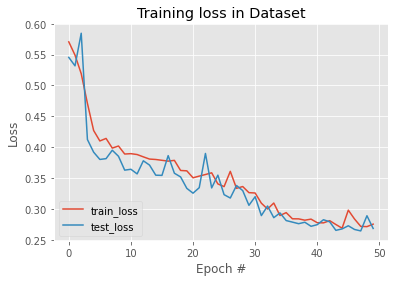

In [8]:
plt.style.use('ggplot')
plt.figure()
plt.plot(H["train_loss"], label='train_loss')
plt.plot(H['test_loss'], label='test_loss')
plt.title('Training loss in Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.savefig(config.BASE_OUTPUT + "/loss_graph#" + str(latest_model_number) + "_cost:{:2.4f}".format(H['test_loss'][-1]) +'.png')